Vragen voor Coen:
- error: std? Want cirkel detectors geven geen onzekerheid. Of kijken naar hoe punten zich relateren tot waar ze "zouden moeten zitten"?
- Hoe vind je punten op grid?
- Mag ik corner detection gebruiken?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.spatial as spatial

%matplotlib widget

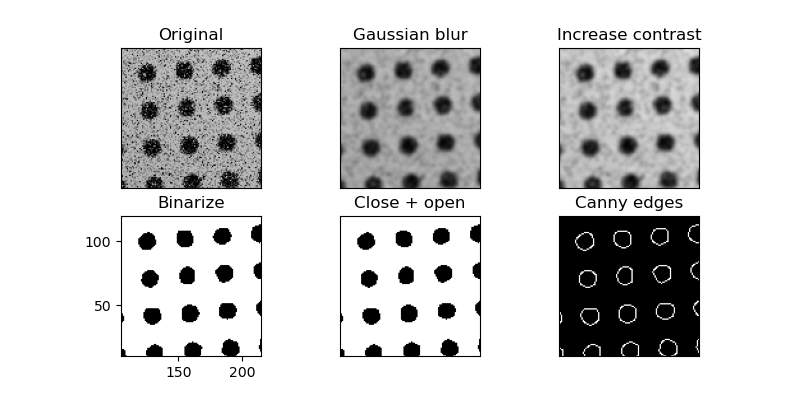

In [2]:
# Parameters
blur_kernel = 7
contrast = 1.2
brightness = 0
binary_kernel = 31
binary_constant = 51
morph_kernel = 5

# Import the realistic image and make a copy
img_dist = cv.imread('Images/Calibration_a/Realistic.png', 0)
img_dist_edit = img_dist.copy()

# Set up a plot, show original image (1)
fig, ax = plt.subplots(2, 3, figsize=(8, 4))
ax[0, 0].imshow(img_dist_edit, cmap='gray')

# Apply a Gaussian blur (2)
img_dist_edit = cv.GaussianBlur(img_dist, (blur_kernel, blur_kernel), 0)
ax[0, 1].imshow(img_dist_edit, cmap='gray')

# Increase the contrast (3)
img_dist_edit = cv.addWeighted(
    img_dist_edit, contrast, img_dist_edit, brightness, 0)
ax[0, 2].imshow(img_dist_edit, cmap='gray')

# Binarize the image with adaptive threshold (4)
img_dist_edit = cv.adaptiveThreshold(
    img_dist_edit, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, binary_kernel, binary_constant)
# _, img_dist_edit = cv.threshold(img_dist_edit, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
ax[1, 0].imshow(img_dist_edit, cmap='gray')

# Close the image with a circular kernel to remove small components (5)
kernel = cv.getStructuringElement(
    cv.MORPH_ELLIPSE, (morph_kernel, morph_kernel))
img_dist_edit = cv.dilate(img_dist_edit, kernel)
img_dist_edit = cv.erode(img_dist_edit, kernel)

# Open the image with the same kernel to fill small holes
img_dist_edit = cv.erode(img_dist_edit, kernel)
img_dist_edit = cv.dilate(img_dist_edit, kernel)
ax[1, 1].imshow(img_dist_edit, cmap='gray')

img_dist_proc = img_dist_edit.copy()

# Edge detection (6)
img_dist_edit = cv.Canny(img_dist_edit, 70, 255)

circles = cv.HoughCircles(img_dist_edit, cv.HOUGH_GRADIENT, 1, 30,
                           param1=140, param2=5,
                           minRadius=3, maxRadius=14)
ax[1, 2].imshow(img_dist_edit, cmap='gray')

# Finish the plot
subplot_names = ['Original', 'Gaussian blur',
                 'Increase contrast', 'Binarize', 'Close + open', 'Canny edges']

for ii, a in enumerate(ax.flatten()):
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlim([105, 215])
    a.set_ylim([10, 120])
    a.set_title(subplot_names[ii])

ax[1,0].set_xticks([150, 200])
ax[1,0].set_yticks([50, 100])
plt.show()

Sub-pixel accuracy??

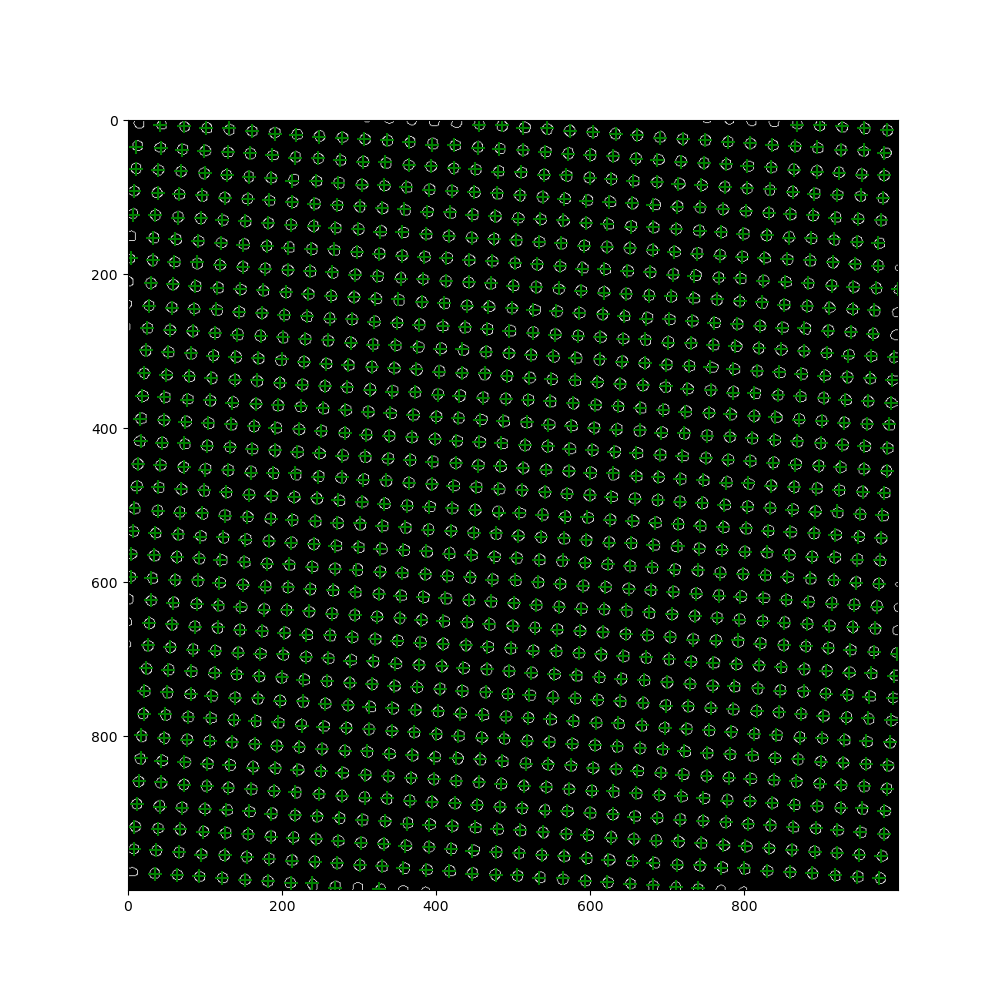

In [3]:
circles = cv.HoughCircles(img_dist_edit, cv.HOUGH_GRADIENT, 0.001, 20,
                           param1=140, param2=12,
                           minRadius=3, maxRadius=14)

# Split circles into x, y and r
circles_x = circles[0, :, 0]
circles_y = circles[0, :, 1]
circles_r = circles[0, :, 2]


# centers = circles[0, :, :2]

# Get an equation for the line between points [101, 10] and [981, 70]
p1 = np.array([101, 10])
p2 = np.array([981, 70])
p1 = np.array([38, 920])
p2 = np.array([918, 980])

# a = (p2[1] - p1[1]) / (p2[0] - p1[0])
# x0 = p1[0]
# b = p1[1]
# eps = 10

# mask = (circles_y < (a * (circles_x - x0) + b) + eps) & (circles_y > (a * (circles_x - x0) + b) - eps)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img_dist_edit, cmap='gray')
plt.scatter(circles[0, :, 0], circles[0, :, 1], c='g', s=100, marker="+")
# plt.xlim([105, 215])
# plt.ylim([105, 215])
plt.show()

img_x = img_dist_edit.shape[0]
img_y = img_dist_edit.shape[1]

In [4]:
# Generate a black image
img_centers = np.zeros_like(img_dist_edit)

# Get the pixel indices surrounding the circle centres,
# and clip them to the image size
x = [np.clip(np.floor(circles_x).astype(int), 0, img_centers.shape[1]-1),
        np.clip(np.ceil(circles_x).astype(int), 0, img_centers.shape[1]-1)]
y = [np.clip(np.floor(circles_y).astype(int), 0, img_centers.shape[0]-1),
        np.clip(np.ceil(circles_y).astype(int), 0, img_centers.shape[0]-1)]

# Color these pixels white
img_centers[y[0], x[0]] = img_centers[y[1], x[1]] = img_centers[y[0], x[1]] = img_centers[y[1], x[0]] = 255

# fig,ax = plt.subplots(figsize=(10,10))
# ax.imshow(img_centers, cmap='gray')


In [5]:
# # Convert the circle centres to polar coordinates from the center of the image
# polar = np.array([circles_x - img_x/2, circles_y - img_y/2])
# circles_r = np.linalg.norm(polar, axis=0)
# circles_th = np.arctan2(polar[1], polar[0])

# # Use a Fourier transform to obtain the grid spacing and angle
# # First, calculate the Fourier transform of the circle centres
# fourier = np.fft.fft2(img_dist_proc)

# # Plot the magnitude and phase of the Fourier transform
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(np.log(np.abs(fourier)**2))  # Magnitude
# ax[1].imshow(np.angle(fourier))  # Phase
# plt.show()

# # Find the peaks in the magnitude of the Fourier transform
# peaks = spatial.cKDTree(np.argwhere(np.log(np.abs(fourier)**2) > 20))

# # Get the distances between the peaks
# distances = np.diff(np.sort(peaks.query(peaks.data, k=2)[1], axis=1))

# # Get the most common distance
# grid_spacing = np.bincount(distances.flatten()).argmax()

# # Get the angle of the grid
# angle = np.arctan2(peaks.data[peaks.query(peaks.data, k=2)[1][:, 1], 0] - peaks.data[peaks.query(peaks.data, k=2)[1][:, 0], 0],
#                    peaks.data[peaks.query(peaks.data, k=2)[1][:, 1], 1] - peaks.data[peaks.query(peaks.data, k=2)[1][:, 0], 1])

# # Get the most common angle
# angle = np.bincount(angle).argmax()

cv2.HoughLines > rotation


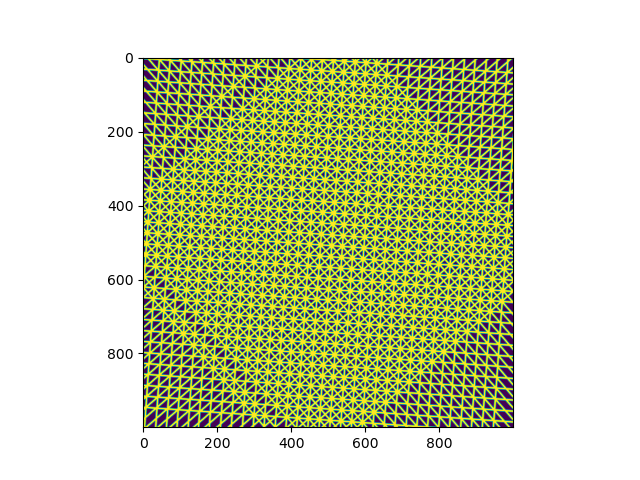

In [6]:
# Perform a Hough line transform with a 1 pixel and 1 degree resolution
#  and a minimum of 20 votes is chosen such that only horizontal, vertical and diagonal lines show up
lines = cv.HoughLines(img_centers, 1, np.pi/180, 20)

img_lines = np.zeros_like(img_dist_edit)
for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
            pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
 
            cv.line(img_lines, pt1, pt2, 255, 3, cv.LINE_AA)

fig, ax = plt.subplots()
ax.imshow(img_lines)

# Extract angles in degrees
lines_angles = np.array([line[0][1]/np.pi*180 for line in lines])

# Round to the nearest 1 degree and consider multiples of 90 degrees
lines_angles = np.round(np.mod(lines_angles,90),1)

# Count the unique angles
angles, angles_cts = np.unique(lines_angles, return_counts=True)

# If only two angles are left, assume the most common angle is the diagonal, so take the other one
if len(angles) == 2:
    angle = angles[angles_cts.argmin()]

    # Convert back to radians
    angle = angle/180*np.pi

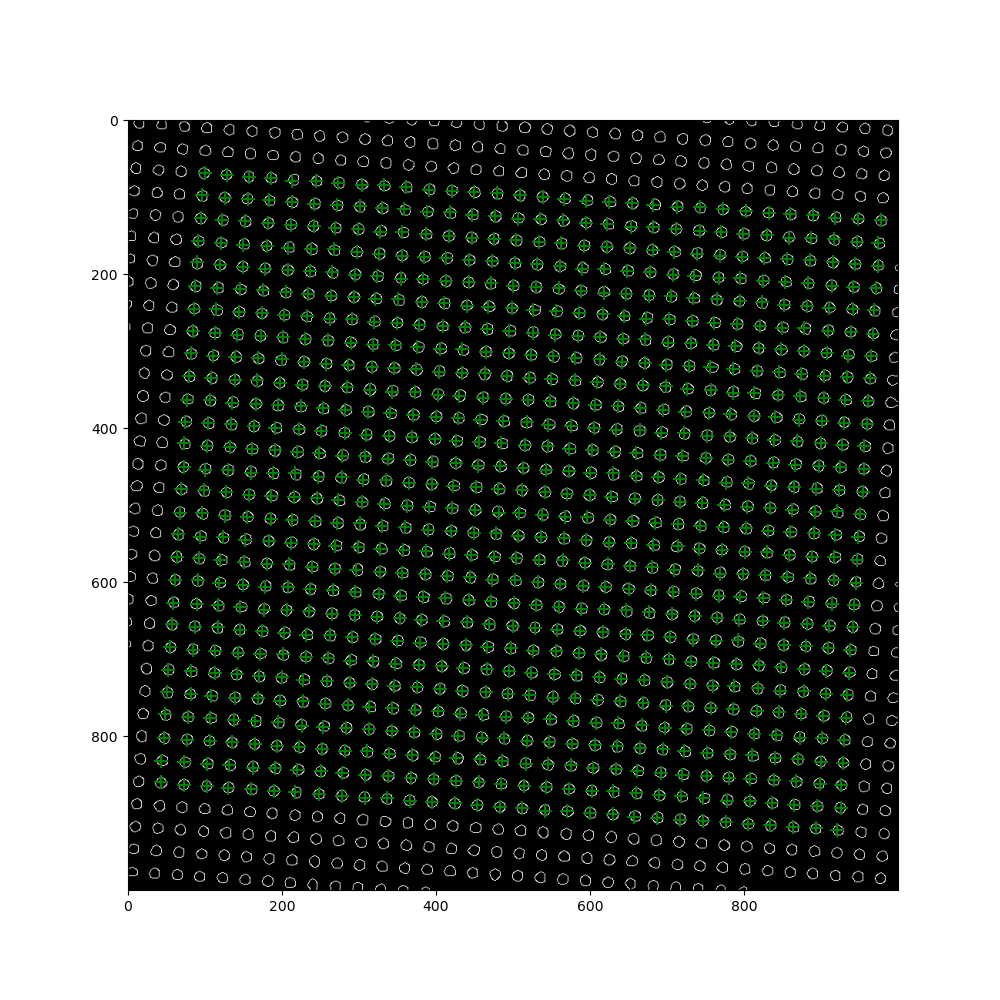

In [18]:
# Define a rectangular mask, rotated by the angle that was found,
# fitting the circles within the boundaries of the image
mask = (circles_y > circles_r +40 + np.tan(angle) * circles_x)\
    & (circles_y < img_y - circles_r -40- np.tan(angle) * (img_x - circles_x))\
    & (circles_x > np.tan(angle) * (img_y - circles_y) + circles_r)\
    & (circles_x < img_x - circles_r - np.tan(angle) * circles_y)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img_dist_edit, cmap='gray')
plt.scatter(circles_x[mask], circles_y[mask], c='g', s=100, marker="+")

plt.show()

In [28]:
# Rotate the circle coordinates back by the angle
rot = np.array([[np.cos(-angle), -np.sin(-angle)],
                [np.sin(-angle), np.cos(-angle)]])
circles_xy = np.array([circles_x[mask], circles_y[mask], circles_r[mask]]).T
circles_xy_rot = np.dot(circles_xy[:,:2], rot.T)

# # Make a scatter plot
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.scatter(circles_xy_rot[:, 1], circles_xy_rot[:, 1], c='g', s=100, marker="+")

# Use a tiny bit of machine learning to get the size of the grid
# (Density-Based Spatial Clustering of Applications with Noise)
# This code is robust to missing points and noise within the grid. However, later on we again assume we have all data points
from sklearn.cluster import DBSCAN

# Sort the circle coordinates by y
circles_xy_rot = circles_xy_rot[circles_xy_rot[:, 1].argsort()]

# Minimum distance between clusters is the average circle diameter
min_dist = 2 * np.mean(circles_xy[:,2])

# Perform clustering in the y direction, fit model to data
dbscan_y = DBSCAN(eps=min_dist, min_samples=2)
dbscan_y.fit(circles_xy_rot[:, 1].reshape(-1, 1))

# Make an array of the cluster numbers in the y direction for each circle
clusters_y = dbscan_y.labels_

# Sort the data points and the clusters_y array by x coordinate
circles_xy_rot = circles_xy_rot[circles_xy_rot[:, 0].argsort()]
clusters_y = clusters_y[circles_xy_rot[:, 0].argsort()]

sort_y = circles_xy_rot[:, 0].argsort()

# # Count the number of clusters
# grid_size = [len(np.unique(dbscan_x.labels_)), len(np.unique(dbscan_y.labels_))]

# # Get an array of the cluster numbers in the x and y direction for each circle
# clusters_x = dbscan_x.labels_
# clusters_y = dbscan_y.labels_

